<a href="https://colab.research.google.com/github/AlexandraKuznetsova1/DataAnalysis2023/blob/main/Reviews_classification_on_amazon_musical_instruments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amazon Music Instrument Reviews**

### Описание датасета

***Классификация отзывов о музыкальных инструментах***

Ссылка: https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews

Датасет одержит следующие столбцы:
1.   **reviewerID** - ID рецензента
2.   **asin** - ID товара
3.   **reviewerName** - имя рецензента
4.   **helpful** - рейтинг полезности отзыва
5.   **reviewText** - текст отзыва
6.   **overall** - рейтинг товара (по 5-балльной шкале)
7.   **summary** - сводка (полученная из текста рецензента)
8.   **unixReviewTime** - время публикации отзыва (unix)
9.   **reviewTime** - время публикации отзыва (raw)

### Команда

- Рафикова Яна, 11-003
- Кузнецова Александра, 11-002
- Мингачев Рустам, 11-003
- Гатин Рамиль, 11-003

### План

- Загрузка данных и описание
- EDA
- Предварительная обработка текста
- SPACY для визуализации текста
- Использование векторизатора TF-IDF для преобразования текстовых данных в разреженную матрицу
- Выбор модели и оценка
  - K Nearest Neighbors Classifier
  - Random Forest Classifier
  - Support Vector Classifier
  - Decision Tree Classifier
  - Logistic Regression



### Data Loading and Description

In [ ]:
# Импорт необходимых библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
# Импортируем датасет и получаем краткую информацию о нем.

music_reviews = pd.read_csv("Musical_instruments_reviews.csv")
music_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
# У нас есть 10261 экземпляр отзывов от различных пользователей и 9 столбцов данных для каждого отзыва об инструменте

music_reviews.shape

(10261, 9)

In [ ]:
music_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [ ]:
# Проверяем столбцы 
# В общей сложности имеем 9 колонок, в основном будем изучать колонку с текстом обзора 

music_reviews.columns

Index(['review', 'rating_label'], dtype='object')

In [ ]:
# Теперь мы собираемся проверить, как распределяются числовые атрибуты нашего набора данных
# Поскольку у нас есть только 2 столбца с числовыми значениями, мы изучаем их

music_reviews.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


### Exploratory Data Analysis

In [ ]:
# Обратим внимание на столбец "Overall", чтобы проверить как распределяется рейтинги товаров.
# Как мы видим, оценки от 1 до 5

music_reviews["overall"].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

<Axes: xlabel='overall', ylabel='count'>

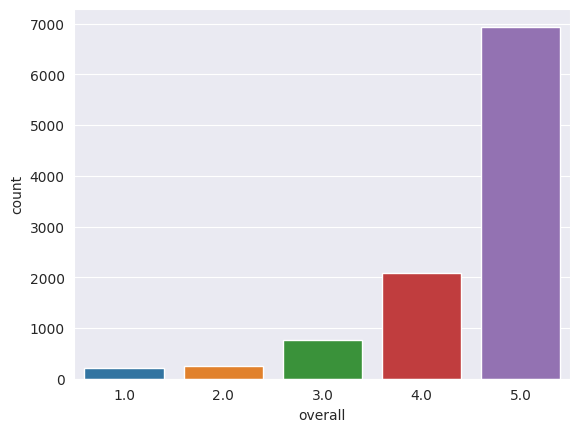

In [ ]:
# Построение графиков различных типов рейтингов, доступных в наших данных

sns.countplot(x = "overall", data = music_reviews)

In [ ]:
# Теперь мы проверяем наличие нулевых значений в столбце "overall"
# Мы видим, что в данных рейтингов нет нулевых значений

music_reviews["overall"].isnull().sum()

0

In [ ]:
# Нам нужны только 2 столбца ("reviewText", "overall") для классификации данных на положительные, отрицательные и нейтральные значения
# Мы создаем новый фрейм данных для нашего дальнейшего анализа с двумя столбцами, упомянутыми выше

music_reviews = music_reviews[["reviewText","overall"]]
music_reviews.head()

,reviewText,overall
0,"Not much to write about here, but it does exac...",5.0
1,The product does exactly as it should and is q...,5.0
2,The primary job of this device is to block the...,5.0
3,Nice windscreen protects my MXL mic and preven...,5.0
4,This pop filter is great. It looks and perform...,5.0


In [ ]:
# Меняем имена столбцов

music_reviews.columns = ["review","rating"]
music_reviews.head()

,review,rating
0,"Not much to write about here, but it does exac...",5.0
1,The product does exactly as it should and is q...,5.0
2,The primary job of this device is to block the...,5.0
3,Nice windscreen protects my MXL mic and preven...,5.0
4,This pop filter is great. It looks and perform...,5.0


Поскольку наши данные содержат 5 отдельных категорий для атрибутов оценок от 1 до 5, мы преобразуем их в положительные, отрицательные и нейтральные следующим образом:

*   Оценки 5 и 4 считаются положительными отзывами -> обозначим "2"
*   Оценка 3 считается нейтральным отзывом -> обозначим "1"
*   Оценки 1 и 2 считаются отрицательными отзывами -> обозначим "0"

In [ ]:
# Преобразование рейтинговых данных в положительные, отрицательные и нейтральные наборы

for i in range(music_reviews.shape[0]):
    if ((music_reviews.rating[i] == 4) or (music_reviews.rating[i] == 5)):
        music_reviews.rating[i] = 2
    elif music_reviews.rating[i] == 3:
        music_reviews.rating[i] = 1
    else:
        music_reviews.rating[i] = 0

<ipython-input-14-3fbb2110d1f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_reviews.rating[i] = 2
<ipython-input-14-3fbb2110d1f4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_reviews.rating[i] = 1
<ipython-input-14-3fbb2110d1f4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_reviews.rating[i] = 0


In [ ]:
music_reviews.head()

,review,rating
0,"Not much to write about here, but it does exac...",2.0
1,The product does exactly as it should and is q...,2.0
2,The primary job of this device is to block the...,2.0
3,Nice windscreen protects my MXL mic and preven...,2.0
4,This pop filter is great. It looks and perform...,2.0


In [ ]:
music_reviews.rename(columns={"rating":"rating_label"},inplace=True)

In [ ]:
# Проверка типа столбца рейтинга
# Столбец рейтинга содержит все значения типа float

type(music_reviews.rating_label[0])

numpy.float64

In [ ]:
# Преобразование значений с плавающей точкой столбца rating_label в значения int для дальнейшего анализа

music_reviews["rating_label"] = music_reviews.rating_label.apply(lambda x: int(x))
music_reviews.head()

,review,rating_label
0,"Not much to write about here, but it does exac...",2
1,The product does exactly as it should and is q...,2
2,The primary job of this device is to block the...,2
3,Nice windscreen protects my MXL mic and preven...,2
4,This pop filter is great. It looks and perform...,2


In [ ]:
# Теперь типом значений в столбце rating_label является целочисленное значение
type(music_reviews.rating_label[0])

numpy.int64

In [ ]:
# Затем провели подсчет столбца rating_label 
# Мы видим, что по нашим данным большинство товаров имеют положительные отзывы

music_reviews.rating_label.value_counts()

2    9022
1     772
0     467
Name: rating_label, dtype: int64

<Axes: xlabel='rating_label', ylabel='count'>

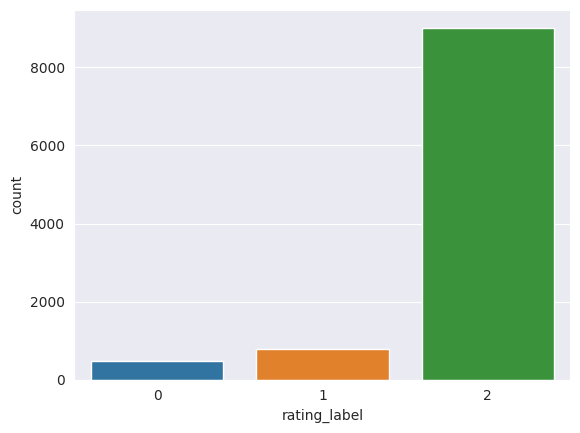

In [ ]:
# Построение графика с использованием seaborn для столбца rating_label

sns.countplot(x = "rating_label", data = music_reviews)

### Text Preprocessing

In [ ]:
# Изучим текстовую информацию, доступную в столбце отзыва

music_reviews.review

0        Not much to write about here, but it does exac...
1        The product does exactly as it should and is q...
2        The primary job of this device is to block the...
3        Nice windscreen protects my MXL mic and preven...
4        This pop filter is great. It looks and perform...
                               ...                        
10256              Great, just as expected.  Thank to all.
10257    I've been thinking about trying the Nanoweb st...
10258    I have tried coated strings in the past ( incl...
10259    Well, MADE by Elixir and DEVELOPED with Taylor...
10260    These strings are really quite good, but I wou...
Name: review, Length: 10261, dtype: object

In [ ]:
# Проверка на NULL-значения 

music_reviews.review.isnull().sum()

7

In [ ]:
# Отбрасываем их

music_reviews.dropna(inplace=True)

In [ ]:
# Импорт nltk и других необходимых элементов для очистки текстовых данных

import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize

In [ ]:
# Проверка знаков препинания, доступных в строке

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Преобразование всего текста в столбце "Обзор" в нижний регистр для дальнейшего анализа

music_reviews.review = music_reviews.review.apply(lambda x: x.lower())

In [ ]:
# Создание токенов для столбца "Обзор" 

import nltk
nltk.download('punkt')

music_reviews.review = music_reviews["review"].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Проверка токенизированных данных на предмет удаления знаков препинания

music_reviews.review

0        [not, much, to, write, about, here, ,, but, it...
1        [the, product, does, exactly, as, it, should, ...
2        [the, primary, job, of, this, device, is, to, ...
3        [nice, windscreen, protects, my, mxl, mic, and...
4        [this, pop, filter, is, great, ., it, looks, a...
                               ...                        
10256    [great, ,, just, as, expected, ., thank, to, a...
10257    [i, 've, been, thinking, about, trying, the, n...
10258    [i, have, tried, coated, strings, in, the, pas...
10259    [well, ,, made, by, elixir, and, developed, wi...
10260    [these, strings, are, really, quite, good, ,, ...
Name: review, Length: 10254, dtype: object

In [ ]:
# Удаляем знаки препинания из наших токенизированных данных
music_reviews.review = music_reviews.review.apply(lambda x: [word for word in x if word not in string.punctuation])
music_reviews.review

0        [not, much, to, write, about, here, but, it, d...
1        [the, product, does, exactly, as, it, should, ...
2        [the, primary, job, of, this, device, is, to, ...
3        [nice, windscreen, protects, my, mxl, mic, and...
4        [this, pop, filter, is, great, it, looks, and,...
                               ...                        
10256          [great, just, as, expected, thank, to, all]
10257    [i, 've, been, thinking, about, trying, the, n...
10258    [i, have, tried, coated, strings, in, the, pas...
10259    [well, made, by, elixir, and, developed, with,...
10260    [these, strings, are, really, quite, good, but...
Name: review, Length: 10254, dtype: object

In [ ]:
# Теперь мы удаляем стоп-слова, которые присутствуют в наших токенизированных данных

import nltk
nltk.download('stopwords')
music_reviews.review = music_reviews.review.apply(lambda x: [word for word in x if word not in stopwords.words("english")])
music_reviews.review

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0        [much, write, exactly, 's, supposed, filters, ...
1        [product, exactly, quite, affordable.i, realiz...
2        [primary, job, device, block, breath, would, o...
3        [nice, windscreen, protects, mxl, mic, prevent...
4        [pop, filter, great, looks, performs, like, st...
                               ...                        
10256                             [great, expected, thank]
10257    ['ve, thinking, trying, nanoweb, strings, bit,...
10258    [tried, coated, strings, past, including, elix...
10259    [well, made, elixir, developed, taylor, guitar...
10260    [strings, really, quite, good, would, n't, cal...
Name: review, Length: 10254, dtype: object

### SPACY for Text Visualization

In [ ]:
# Импорт необходимых библиотек spacy и displacy для визуализации 
!python -m spacy download en_core_web_sm
import spacy
from spacy import displacy

2023-05-21 11:30:43.992613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Инициализация spacy 

nlp = spacy.load("en_core_web_sm")

In [ ]:
# Берем review в виде текста и применяем его в spacy 

text = nlp(" ".join(music_reviews["review"][0]))
text

much write exactly 's supposed filters pop sounds recordings much crisp one lowest prices pop filters amazon might well buy honestly work despite pricing

In [ ]:
# Определение частей речи
options = {"distance":50,"compact":"True","color":"yellow","bg":"green"}
displacy.render(text,style="dep",jupyter=True,options=options)

In [ ]:
# Мы также можем открыть это на отдельной странице, используя опцию "serve".

# new_options = {"distance":100,"compact":"True","color":"yellow","bg":"green"}
# displacy.serve(text,style="dep",options=new_options)

In [ ]:
# Также мы можем проверить распознавание именованных сущностей с помощью библиотек Spacy и displacy
displacy.render(text,style="ent",jupyter=True)

### Using TF-IDF vectorizer to convert the textual data into a sparse matrix






In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Инициализация векторизатора TF-IDF для объекта tfidf

tfidf = TfidfVectorizer(max_features=5000,preprocessor=" ".join)

In [ ]:
# Вставка входных объектов в векторизатор TF-IDF

review_features = tfidf.fit_transform(music_reviews.review)

In [ ]:
# получили разреженную матрицу с функциями из столбца обзора
# попытаемся применить эту модель к алгоритмам машинного обучения для классификации текста

In [ ]:
# Теперь review_features - это наши входные данные для дальнейшего анализа
# Поскольку мы выбрали max_features равным 5000, мы получили форму матрицы, как показано ниже

review_features.shape

(10254, 5000)

In [ ]:

y = music_reviews["rating_label"]
y.shape

(10254,)

In [ ]:
# Метод Counter дает нам количество типов
# Мы видим, что в столбце рейтинга для нас есть 3 конкретных типа меток

from collections import Counter
Counter(y)

Counter({2: 9015, 1: 772, 0: 467})

In [ ]:
# Разделение данных на обучающие и тестовые 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(review_features, y, test_size=0.3, random_state=101)

In [ ]:
X_train, y_train

(<7177x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 253961 stored elements in Compressed Sparse Row format>,
 8021    2
 9351    2
 4295    2
 1572    2
 4506    2
        ..
 599     2
 5697    2
 8008    1
 1361    2
 1547    2
 Name: rating_label, Length: 7177, dtype: int64)

### Model Selection and Evaluation

In [ ]:
# Импорт необходимых показателей для оценки модели

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
accuracy_list=[]

##### K Nearest Neighbors Classifier

In [ ]:
# Импорт метода k ближайших соседей из sklearn (KNeighborsClassifier)

from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Обучение модели

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Прогнозирование производительности модели

knn_predictions = knn.predict(X_test)

In [ ]:
# Оценка производительности модели KNN

confusion_matrix(knn_predictions,y_test)

array([[  11,    4,   49],
       [   2,    8,   41],
       [ 126,  211, 2625]])

<Axes: >

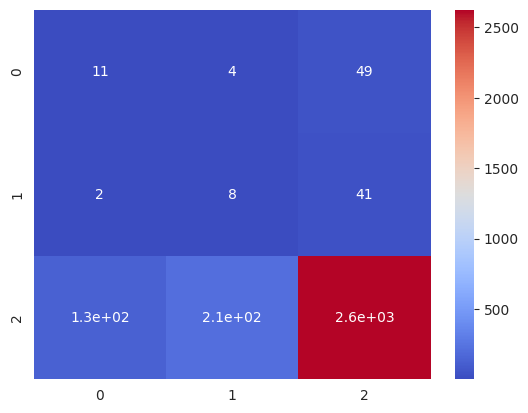

In [ ]:
# Построение тепловой карты матрицы ошибок с использованием результатов модели

sns.heatmap(confusion_matrix(knn_predictions,y_test),cmap="coolwarm",annot=True)

In [ ]:
# Отчет о классификации характеристик нашей модели для проверки Precision, Recall and F1-Score

print(classification_report(knn_predictions,y_test))

              precision    recall  f1-score   support

           0       0.08      0.17      0.11        64
           1       0.04      0.16      0.06        51
           2       0.97      0.89      0.92      2962

    accuracy                           0.86      3077
   macro avg       0.36      0.40      0.36      3077
weighted avg       0.93      0.86      0.89      3077



In [ ]:
# Проверка оценки точности наших данных с помощью K Nearnest Neighbors Classifier

knn_acc=accuracy_score(knn_predictions,y_test).round(2)
accuracy_list.append(knn_acc)
knn_acc

0.86

### Random Forest Classifier

In [ ]:
# Импорт Random Forest Classifier из the sklearn

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Построение модели

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Прогнозирование производительности модели

rf_predictions = rf_classifier.predict(X_test)

<Axes: >

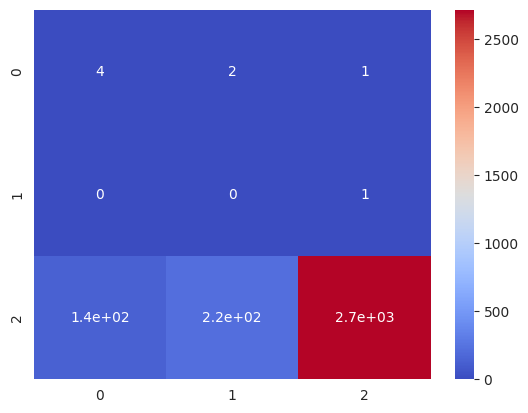

In [ ]:
# Оценка производительности модели с использованием матрицы ошибок
sns.heatmap(confusion_matrix(rf_predictions,y_test),cmap="coolwarm",annot=True)

In [ ]:
# Отчет о классификации характеристик нашей модели для проверки Precision, Recall and F1-Score

print(classification_report(rf_predictions,y_test))

              precision    recall  f1-score   support

           0       0.03      0.57      0.05         7
           1       0.00      0.00      0.00         1
           2       1.00      0.88      0.94      3069

    accuracy                           0.88      3077
   macro avg       0.34      0.49      0.33      3077
weighted avg       1.00      0.88      0.94      3077



In [ ]:
# Проверка оценки точности наших данных с помощью Random Forest Classifier

rf_acc=accuracy_score(rf_predictions,y_test).round(2)
accuracy_list.append(rf_acc)
rf_acc

0.88

### Linear Support Vector Classifier

In [ ]:
# Импорт метода линейных опорных векторов (Linear Support vector classifier)

from sklearn.svm import LinearSVC

In [ ]:
# Построение модели

sv_classifier = LinearSVC()
sv_classifier.fit(X_train, y_train)

LinearSVC()

In [ ]:
# Прогнозирование производительности модели

sv_predictions = sv_classifier.predict(X_test)

<Axes: >

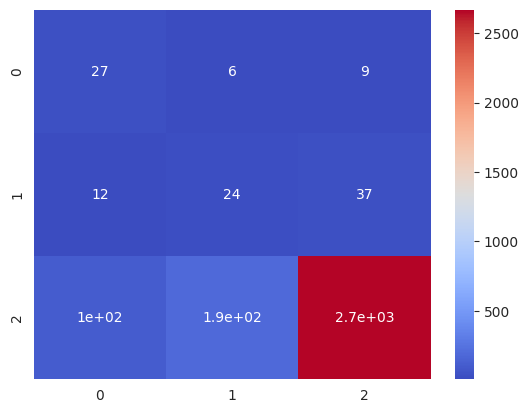

In [ ]:
# Оценка производительности модели с использованием тепловой карты и матрицы ошибок

sns.heatmap(confusion_matrix(sv_predictions,y_test),cmap="coolwarm",annot=True)

In [ ]:
# Отчет о классификации характеристик нашей модели для проверки Precision, Recall and F1-Score

print(classification_report(sv_predictions,y_test))

              precision    recall  f1-score   support

           0       0.19      0.64      0.30        42
           1       0.11      0.33      0.16        73
           2       0.98      0.90      0.94      2962

    accuracy                           0.88      3077
   macro avg       0.43      0.62      0.47      3077
weighted avg       0.95      0.88      0.91      3077



In [ ]:
# Проверяем оценку точности наших данных с помощью Linear Support Vector Classifier

lsvc_acc=accuracy_score(sv_predictions,y_test).round(2)
accuracy_list.append(lsvc_acc)
lsvc_acc

0.88

##### Support Vector Classifier

In [ ]:
# Импортируем классификатор опорных векторов из sklearn

from sklearn.svm import SVC

In [ ]:
# Строим модель с использованием машинного классификатора опорных векторов

svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [ ]:
# Проверяем предсказания нашей модели

svc_predictions = svc.predict(X_test)

<Axes: >

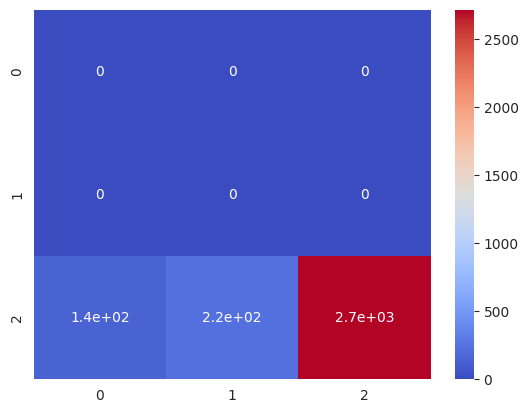

In [ ]:
# Оцениваем производительность модели с использованием тепловой карты и матрицы путаницы

sns.heatmap(confusion_matrix(svc_predictions,y_test),cmap="coolwarm",annot=True)

In [ ]:
# Отчет о классификации характеристик нашей модели для проверки Precision, Recall and F1-Score

print(classification_report(svc_predictions,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.88      0.94      3077

    accuracy                           0.88      3077
   macro avg       0.33      0.29      0.31      3077
weighted avg       1.00      0.88      0.94      3077



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Проверяем оценку точности наших данных с помощью классификатора опорных векторов

svc_acc=accuracy_score(svc_predictions,y_test).round(2)
accuracy_list.append(svc_acc)
svc_acc

0.88

##### Decision Tree Classifier

In [ ]:
# Импортируем классификатор дерева решений из sklearn

from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Строим модель с использованием классификатора дерева решений

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
# Проверяем предсказания нашей модели

dt_predictions = dt.predict(X_test)

<Axes: >

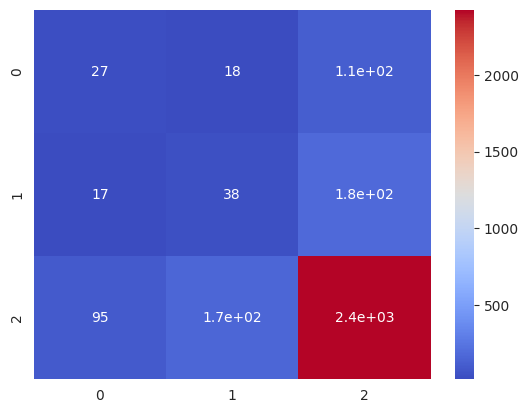

In [ ]:
# Оцениваем производительность модели с использованием тепловой карты и матрицы путаницы

sns.heatmap(confusion_matrix(dt_predictions,y_test),cmap="coolwarm",annot=True)

In [ ]:
# Отчет о классификации характеристик нашей модели для проверки Precision, Recall and F1-Score

print(classification_report(dt_predictions,y_test))

              precision    recall  f1-score   support

           0       0.19      0.17      0.18       157
           1       0.17      0.16      0.17       234
           2       0.89      0.90      0.90      2686

    accuracy                           0.81      3077
   macro avg       0.42      0.41      0.42      3077
weighted avg       0.80      0.81      0.81      3077



In [ ]:
# Проверяем оценку точности наших данных с помощью классификатора дерева решений

dtc_acc=accuracy_score(dt_predictions,y_test).round(2)
accuracy_list.append(dtc_acc)
dtc_acc

0.81

##### Logistic Regression

In [ ]:
# Импортируем логистическую регрессию из sklearn

from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [ ]:
lr_predictions = lr.predict(X_test)

<Axes: >

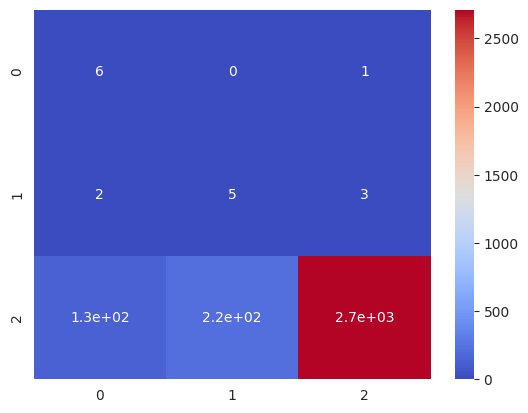

In [ ]:
# Оценка производительности модели с использованием тепловой карты и матрицы путаницы

sns.heatmap(confusion_matrix(lr_predictions,y_test),cmap="coolwarm",annot=True)

In [ ]:
# Отчет о классификации характеристик нашей модели для проверки Precision, Recall and F1-Score

print(classification_report(lr_predictions,y_test))

              precision    recall  f1-score   support

           0       0.04      0.86      0.08         7
           1       0.02      0.50      0.04        10
           2       1.00      0.89      0.94      3060

    accuracy                           0.88      3077
   macro avg       0.35      0.75      0.35      3077
weighted avg       0.99      0.88      0.93      3077



In [ ]:
# Проверяем оценку точности наших данных с помощью логистической регрессии

lr_acc=accuracy_score(lr_predictions,y_test).round(2)
accuracy_list.append(lr_acc)
lr_acc

0.88

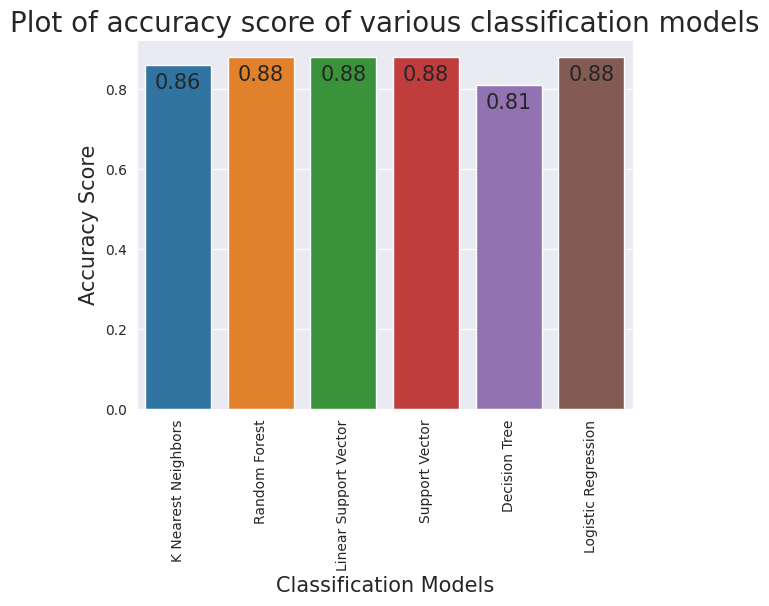

In [ ]:
# Строим оценки точности применяемых моделей
accuracy_labels=["K Nearest Neighbors","Random Forest","Linear Support Vector","Support Vector","Decision Tree","Logistic Regression"]
ax=sns.barplot(x=accuracy_labels, y=accuracy_list)
plt.title('Plot of accuracy score of various classification models',fontsize=20)
plt.xlabel('Classification Models',fontsize=15)
plt.ylabel('Accuracy Score',fontsize=15)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, -12),
                   textcoords='offset points')
plt.xticks(rotation=90)
plt.show()

## Выводы

* На основе результатов работы модели текстовой классификации мы можем сделать вывод, что все модели, которые мы применили, сработали с точностью не менее, чем  80-88 процентов. Все модели достаточно хорошо справляются с прогнозированием положительных отзывов о наших данных.
* Но большинство моделей не оправдали ожиданий с нейтральными и отрицательными отзывами, поскольку у нашей модели их гораздо меньше.
* Только линейный классификатор опорных векторов способен хорошо предсказывать положительные, отрицательные и нейтральные отзывы. Точность модели линейного опорного вектора составляет 88%, и мы можем видеть лучшие результаты отзыва и точности для отрицательных и нейтральных отзывов наряду с положительными отзывами.


В заключение стоит отметить, что с положительной стороны, мы можем достичь точности в 88% с помощью линейного классификатора опорных векторов, который довольно хорош в прогнозировании отзывов об инструменте.